In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
# Load the dataset
file_path = '/content/TEC_FLARE AND STORM DATASET.xlsx'  # Replace with the correct file path
df = pd.read_excel(file_path)

In [3]:
df.head()

,TIME,TRUE TEC,KP,SSN,AP,F10.7,IRI_TEC
0,2023-08-01 00:00:00,9.2562,20,180,7,179.9,NaN
1,2023-08-01 01:00:00,16.8680,20,180,7,179.9,NaN
2,2023-08-01 02:00:00,27.4030,20,180,7,179.9,NaN
3,2023-08-01 03:00:00,37.1210,17,180,6,179.9,NaN
4,2023-08-01 04:00:00,47.9440,17,180,6,179.9,NaN


In [4]:
df.columns = df.columns.str.strip()

In [5]:
# Check for data types in the 'TIME' column
print(df['TIME'].apply(type).value_counts())  # To identify any issues with data types

# Convert 'TIME' column to datetime, handling errors
df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')

# Check if any rows have NaT values after conversion
invalid_time_rows = df[df['TIME'].isna()]
print(f"Number of invalid TIME entries: {len(invalid_time_rows)}")

# Drop rows where 'TIME' conversion failed (optional: you can also fill NaT with a default date)
df.dropna(subset=['TIME'], inplace=True)

# Ensure the dataframe is sorted by the 'TIME' column
df.sort_values(by='TIME', inplace=True)

TIME
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    10608
Name: count, dtype: int64
Number of invalid TIME entries: 0


In [6]:
# Convert TIME to datetime and extract time-related features
df['TIME'] = pd.to_datetime(df['TIME'])
df['Hour'] = df['TIME'].dt.hour
df['Day'] = df['TIME'].dt.day
df['Month'] = df['TIME'].dt.month
df['Year'] = df['TIME'].dt.year
df.set_index('TIME', inplace=True)
#df.drop('TIME', axis=1, inplace=True)  # Drop the TIME column

# Add cyclical features for Hour
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

In [7]:
# Check for the maximum date to avoid the KeyError
max_date = df.index.max()
print(f"Max date in the dataset: {max_date}")

Max date in the dataset: 2024-10-15 23:00:00


In [8]:
print(df.isna().sum())  # Shows NaN count for each column

TRUE TEC       0
KP             0
SSN            0
AP             0
F10.7          0
IRI_TEC     9600
Hour           0
Day            0
Month          0
Year           0
Hour_sin       0
Hour_cos       0
dtype: int64


CHANGE THE PREDICTION DATES AS IF REQUIRED (FLARE & STORM)

In [17]:
# Define features (X) and target (y)
X = df.drop(['TRUE TEC','IRI_TEC'],axis=1)
y = df['TRUE TEC']

#flare
#x6.7
prediction_dates = ['2024-02-18','2024-02-19','2024-02-20','2024-02-21','2024-02-22','2024-02-23','2024-02-24','2024-02-25','2024-02-26']
#x8.7
#prediction_dates = ['2024-05-10','2024-05-11','2024-05-12','2024-05-13','2024-05-14','2024-05-15','2024-05-16','2024-05-17','2024-05-18']

#storm
#prediction_dates = ['2024-05-06','2024-05-07','2024-05-08','2024-05-09','2024-05-10','2024-05-11','2024-05-12','2024-05-13','2024-05-14','2024-05-15','2024-05-16','2024-05-17']
#prediction_dates = ['2024-10-06','2024-10-07','2024-10-08','2024-10-09','2024-10-10','2024-10-11','2024-10-12','2024-10-13','2024-10-14','2024-10-15']

TRAIN THE DATASET WITH RANDOM FOREST AND XGBOOST MODEL(i.e the model is trained upto the previous day of each prediction date)

In [18]:

predicted_values_rf = {}
true_values_rf = {}
predicted_values_xg = {}
true_values_xg = {}
iri_values = {}

for date in prediction_dates:
    train_end_date = pd.to_datetime(date) - pd.Timedelta(days=1)
    print(train_end_date)
    X_train = X[:str(train_end_date)]
    y_train = y[:str(train_end_date)]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Generate polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_scaled)

    # Train models
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_poly, y_train)

    xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_poly, y_train)



    if str(pd.to_datetime(date)) in df.index:
        input_features = df.loc[date, X.columns]
        iri_values[date] = df.loc[date, 'IRI_TEC'].values.flatten() if 'IRI_TEC' in df.columns else None

        if input_features.shape[0] == 24:
            input_features_scaled = scaler.transform(input_features)
            input_features_poly = poly.transform(input_features_scaled)

            predicted_tec_rf = rf_model.predict(input_features_poly)
            predicted_tec_xg = xgb_model.predict(input_features_poly)

            predicted_values_rf[date] = predicted_tec_rf
            predicted_values_xg[date] = predicted_tec_xg
            true_values_rf[date] = df.loc[date, 'TRUE TEC'].values
            true_values_xg[date] = df.loc[date, 'TRUE TEC'].values
        else:
            print(f"Insufficient data for {date}, skipping prediction.")
    else:
        print(f"No data available for {date}, skipping prediction.")

2024-02-17 00:00:00
2024-02-18 00:00:00
2024-02-19 00:00:00
2024-02-20 00:00:00
2024-02-21 00:00:00
2024-02-22 00:00:00
2024-02-23 00:00:00
2024-02-24 00:00:00
2024-02-25 00:00:00


FOR PRINTING PREDICTED AND TRUE TEC VALUES (RF &XG)

In [19]:
# Evaluation and plotting
all_true_tec_rf, all_predicted_tec_rf, time_labels_rf = [], [], []
all_true_tec_xg, all_predicted_tec_xg, time_labels_xg = [], [], []

all_iri_tec_xg, all_iri_tec_rf = [], []

def gather_predictions(predicted_values, true_values, all_true_tec, all_predicted_tec, all_iri_tec, time_labels):
    for date in prediction_dates:
        if date in predicted_values and date in true_values:
            all_true_tec.extend(true_values[date])
            all_predicted_tec.extend(predicted_values[date])
            all_iri_tec.extend(iri_values[date])

            time_labels.extend([f'{date} {hour}:00' for hour in range(24)])

gather_predictions(predicted_values_rf, true_values_rf, all_true_tec_rf, all_predicted_tec_rf, all_iri_tec_rf, time_labels_rf)
gather_predictions(predicted_values_xg, true_values_xg, all_true_tec_xg, all_predicted_tec_xg, all_iri_tec_xg, time_labels_xg)

In [20]:
print(all_true_tec_rf)
print(all_predicted_tec_rf)
print(all_predicted_tec_xg)
print(all_iri_tec_xg)
print(all_iri_tec_rf)

[np.float64(11.83424550855624), np.float64(12.9770030687491), np.float64(26.01617577639706), np.float64(39.34109809855075), np.float64(53.23519836999778), np.float64(64.01560537774938), np.float64(71.73470513220339), np.float64(81.61344695218365), np.float64(85.74580406437366), np.float64(86.75914091244863), np.float64(87.15858120402073), np.float64(83.98004638578374), np.float64(79.6814968131498), np.float64(74.5482904021162), np.float64(59.11961136802989), np.float64(39.36887709383356), np.float64(37.06578245502436), np.float64(39.37574916001634), np.float64(45.23012819278483), np.float64(45.84985986547645), np.float64(41.68744037914242), np.float64(36.71049520898975), np.float64(28.49945740722623), np.float64(16.73966578128557), np.float64(12.40961622459716), np.float64(12.91288162901481), np.float64(25.54274158898736), np.float64(41.74552813073943), np.float64(59.39660815254661), np.float64(69.86600280217941), np.float64(73.13302187234041), np.float64(78.5501534460796), np.float64(

EVALUATION OF THE MODEL(R2, SMAPE, MSLE)

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(all_true, all_predicted, model_name, prediction_dates, true_values_dict, predicted_values_dict):
    # Convert lists to NumPy arrays
    y_true = np.array(all_true, dtype=float).flatten()
    y_pred = np.array(all_predicted, dtype=float).flatten()

    # Avoid log(0) issue by adding 1 to all values
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    # Compute MSLE
    msle_value = np.mean((log_true - log_pred) ** 2)

    # Other metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5

    # R² Calculation (Per date, then averaged)
    r2_scores = []
    for date in prediction_dates:
        if date in true_values_dict and date in predicted_values_dict:
            true_tec = np.array(true_values_dict[date], dtype=float).flatten()
            predicted_tec = np.array(predicted_values_dict[date], dtype=float).flatten()

            if len(true_tec) == 24 and len(predicted_tec) == 24:  # Ensure 24 values per day
                r2 = r2_score(true_tec, predicted_tec)
                r2_scores.append(r2)

    r2 = np.mean(r2_scores) if r2_scores else None  # Average R² if available

    # Compute SMAPE
    all_true = np.array(all_true, dtype=float)
    all_predicted = np.array(all_predicted, dtype=float)
    numerator = np.abs(all_true - all_predicted)
    denominator = (np.abs(all_true) + np.abs(all_predicted)) / 2
    smape_value = np.mean(numerator / denominator) * 100  # Convert to percentage
    accuracy = 100 - smape_value

    print(f"{model_name} Model Evaluation:")
    print(f"R²: {r2:.4f}, MSLE: {msle_value:.4f},SMAPE : {smape_value:.4f}%, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Example Call (Replace these variables with actual data)
evaluate_model(all_true_tec_rf, all_predicted_tec_rf, "Random Forest", prediction_dates, true_values_rf, predicted_values_rf)
evaluate_model(all_true_tec_xg, all_predicted_tec_xg, "XGBoost", prediction_dates, true_values_xg, predicted_values_xg)
evaluate_model(all_true_tec_rf,all_iri_tec_rf,"IRI Values (RF)",prediction_dates,true_values_rf,iri_values)

Random Forest Model Evaluation:
R²: 0.9235, MSLE: 0.0297,SMAPE : 13.2801%, MAE: 5.1905, MSE: 45.2055, RMSE: 6.7235

XGBoost Model Evaluation:
R²: 0.9380, MSLE: 0.0304,SMAPE : 12.7651%, MAE: 4.6758, MSE: 36.6897, RMSE: 6.0572

IRI Values (RF) Model Evaluation:
R²: 0.4720, MSLE: 0.1504,SMAPE : 34.7102%, MAE: 15.0744, MSE: 320.0697, RMSE: 17.8905



LINEAR REGRESSION PLOT

216 216 216


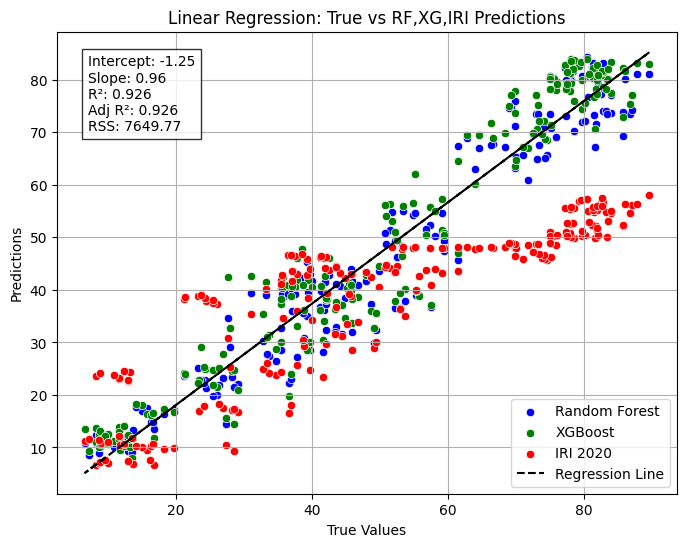

In [22]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example values (Replace these with your actual data)
true_values = np.array(all_true_tec_rf)   # Your true values (X)
rf_predictions = np.array(all_predicted_tec_rf)  # Your Random Forest predictions (Y)
xg_predictions = np.array(all_predicted_tec_xg)  # Your XGBoost predictions (Y)
iri_2020_predictions = np.array(all_iri_tec_rf)  # IRI 2020 predictions
print(len(true_values), len(rf_predictions), len(iri_2020_predictions))

# Compute mean values
X_mean = np.mean(true_values)
Y_mean = np.mean(rf_predictions)

# Compute slope (β₁)
slope = np.sum((true_values - X_mean) * (rf_predictions - Y_mean)) / np.sum((true_values - X_mean) ** 2)

# Compute intercept (β₀)
intercept = Y_mean - slope * X_mean

# Compute predicted values using the regression model (but not needed for final plot)
regression_predictions = intercept + slope * true_values  # Only used for R² and RSS

# Compute R²
ss_total = np.sum((rf_predictions - Y_mean) ** 2)  # Total Sum of Squares (TSS)
ss_residual = np.sum((rf_predictions - regression_predictions) ** 2)  # Residual Sum of Squares (RSS)
#r2 = 1 - (ss_residual / ss_total)
r2 = r2_score(true_values, rf_predictions)

# Compute Adjusted R²
n = len(true_values)  # Number of observations
p = 1  # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Compute Residual Sum of Squares (RSS)
rss = ss_residual

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=true_values, y=rf_predictions, label="Random Forest", color="blue")
sns.scatterplot(x=true_values, y=xg_predictions, label="XGBoost", color="green")
sns.scatterplot(x=true_values, y=iri_2020_predictions, label="IRI 2020", color="red")

# Regression Line (Using True Values)
plt.plot(true_values, regression_predictions, color="black", linestyle="dashed", label="Regression Line")

# Statistics Box (Top-left corner)
textstr = f"Intercept: {intercept:.2f}\nSlope: {slope:.2f}\nR²: {r2:.3f}\nAdj R²: {adj_r2:.3f}\nRSS: {rss:.2f}"
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# Labels & Legend
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression: True vs RF,XG,IRI Predictions")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [23]:
# Create new x-ticks at the center of each 24-hour period
num_days = len(prediction_dates)
ticks = np.arange(12, num_days * 24, 24)  # Center ticks at 12, 36, 60, etc.

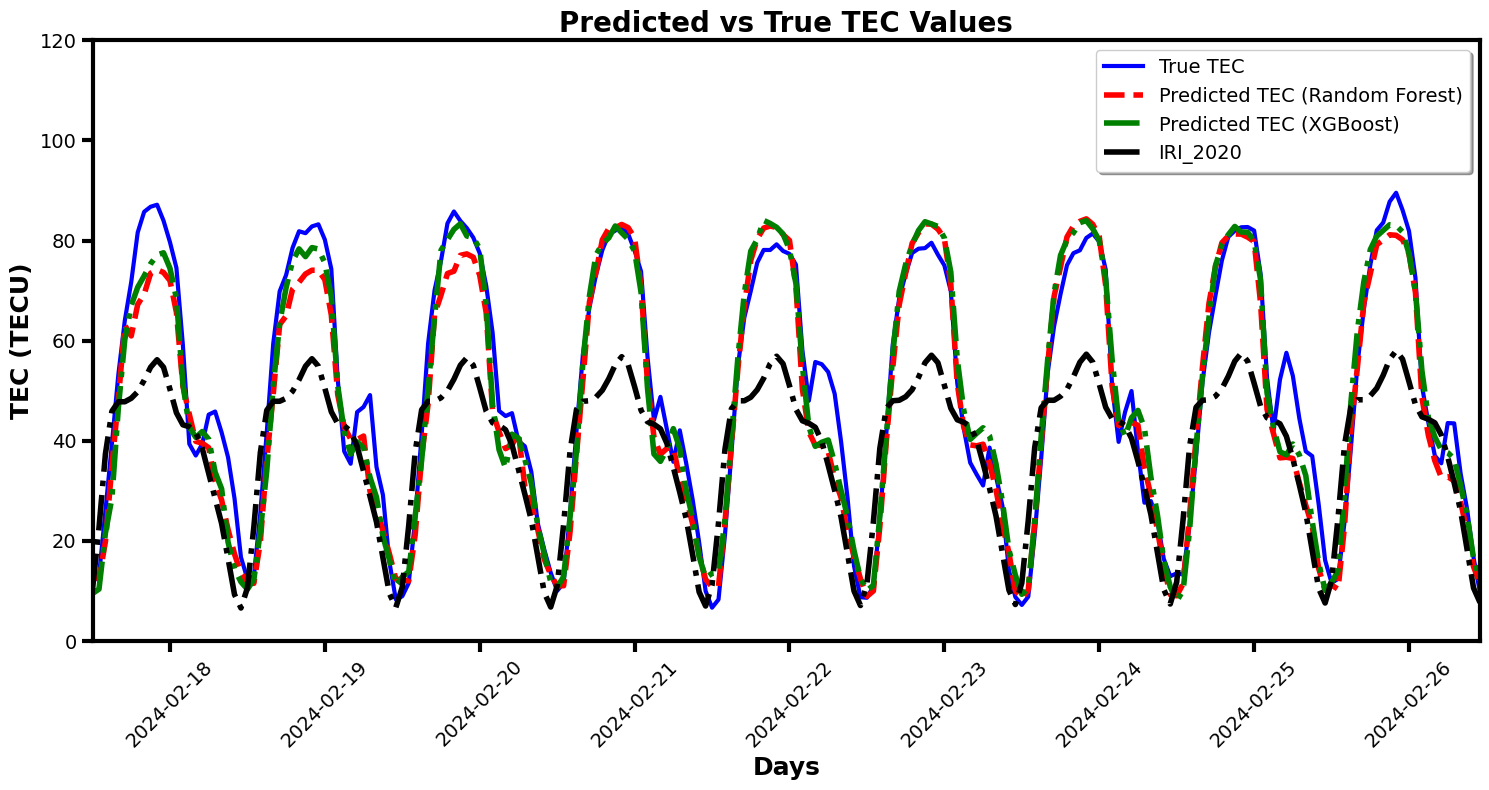

In [24]:
# Plotting the refined graph with smoothed values
plt.figure(figsize=(15, 8))

# Plot the true TEC, Random Forest, and XGBoost TEC values
plt.plot(all_true_tec_rf, label='True TEC', color='blue', linewidth=3)
plt.plot(all_predicted_tec_rf, label='Predicted TEC (Random Forest)', color='red', linestyle='--', linewidth=4)
plt.plot(all_predicted_tec_xg, label='Predicted TEC (XGBoost)', color='green', linestyle='-.', linewidth=4)
plt.plot(all_iri_tec_rf, label='IRI_2020', color='black', linestyle='dashdot', linewidth=4)


# Set x-axis ticks at regular intervals (centered at the middle of each day)
plt.xticks(ticks=ticks, labels=prediction_dates, rotation=45, ha='center')

# Adjust the graph appearance
plt.title('Predicted vs True TEC Values', fontsize=20, fontweight='bold')
plt.xlabel('Days', fontsize=18, fontweight='bold')
plt.ylabel('TEC (TECU)', fontsize=18, fontweight='bold')
plt.ylim(0, 120)
plt.legend(fontsize=14, loc='upper right', frameon=True, shadow=True)
plt.xlim(0, len(all_true_tec_rf) - 1)

# Set tick parameters to increase thickness
plt.tick_params(axis='both', which='major', labelsize=14, width=3, length=8)

# Increase axis thickness
ax = plt.gca()
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)

plt.tight_layout()
plt.show()